In [1]:
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2025-12-31 10:36:04.174147: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-31 10:36:04.224668: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-31 10:36:05.616490: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-31 10:36:20.615654: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

### 1) Data Collection
- Downloaded Microsoft stock data for the last 5 years using yfinance.

In [2]:
data = yf.download("MSFT", period="5y")
data.sort_index(inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2020-12-31,213.420807,213.977342,210.791663,212.729937,20942100
2021-01-04,208.882187,213.977340,206.118708,213.526355,37130100
2021-01-05,209.083725,209.678650,206.972740,208.469620,23823000
2021-01-06,203.662308,207.730761,203.364853,203.585543,35930700
2021-01-07,209.457947,210.465467,205.063267,205.379902,27694500


### 2) Data Preprocessing
- Extracted the 'Close' price as the time series.
- Checked for missing values and filled them using forward fill.
- Split the dataset into: Training set: 80%, Testing set: 20%

In [3]:
df = data["Close"]

# to check if it has empty values
df.info()

# to handle missing values using forward fill
df.fillna(method="ffill", inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1255 entries, 2020-12-31 to 2025-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MSFT    1255 non-null   float64
dtypes: float64(1)
memory usage: 19.6 KB


In [4]:
# train-test split
train, test = train_test_split(df, test_size=0.2, shuffle=False)

### Stationarity test (ADF)

Run the Augmented Dickey-Fuller test on the training set. If non-stationary, consider differencing.

In [5]:
adf_result = adfuller(train)
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

if adf_result[1] < 0.05:
    print('Series is stationary')
    d_value = 0
else:
    print('Series is non-stationary; differencing is needed')
    d_value = 1

ADF Statistic: -0.858891
p-value: 0.801209
Series is non-stationary; differencing is needed


### ACF and PACF plots

Used these to get an initial idea for ARIMA p and q values.

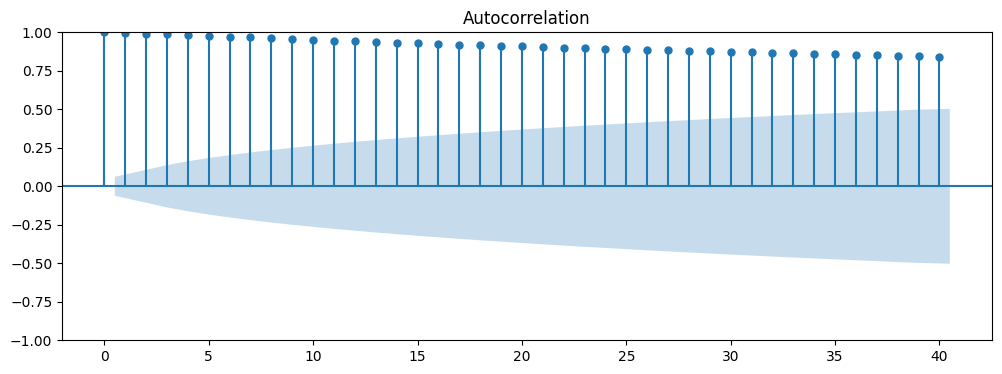

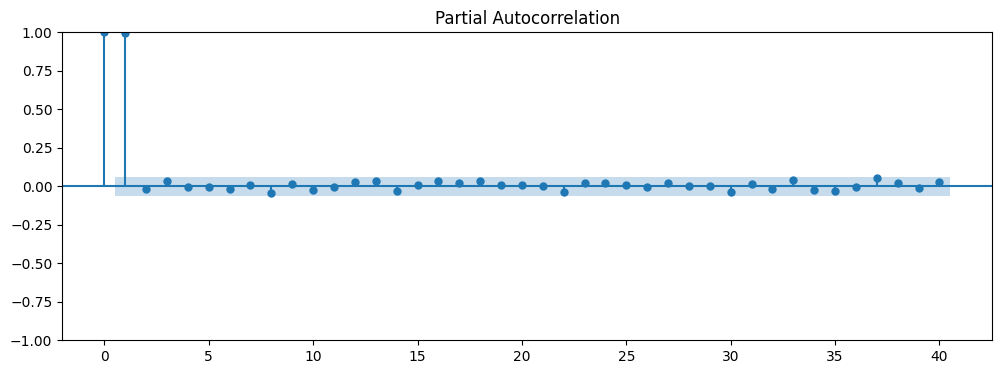

In [6]:
plt.figure(figsize=(12,4))
plot_acf(train, lags=40, ax=plt.gca())
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(train, lags=40, ax=plt.gca(), method='ywm')
plt.show()


### 3) ARIMA Model
- The Augmented Dickey–Fuller test indicated non-stationarity in the original series, which became stationary after first differencing. The PACF of the differenced series showed significant spikes at lags 1 and 2 and cut off thereafter, while the ACF decayed gradually. This pattern is characteristic of an AR(2) process. Hence, an ARIMA(2,1,0) model was selected

In [7]:
# Fit the ARIMA model to the training data
model = ARIMA(train, order=(2,1,0))
model_fit = model.fit()

/mnt/c/Users/mahan/Documents/vscode/DataScience/jupyter-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/c/Users/mahan/Documents/vscode/DataScience/jupyter-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/c/Users/mahan/Documents/vscode/DataScience/jupyter-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/mnt/c/Users/mahan/Documents/vscode/DataScience/jupyter-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


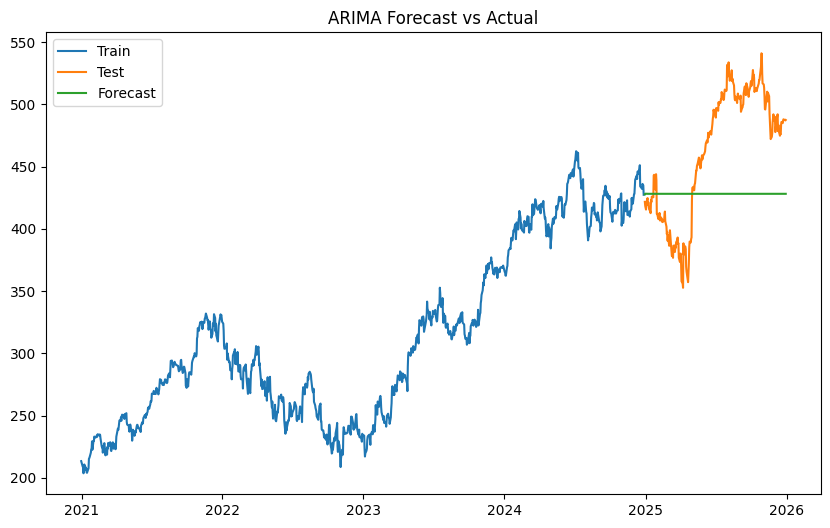

In [8]:
# Forecast
forecast = model_fit.forecast(steps=len(test))
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

In [9]:
# Evaluation of Preformance
arima_mae = mean_absolute_error(test, forecast)
arima_mse = mean_squared_error(test, forecast)
arima_rmse = np.sqrt(arima_mse)
arima_mape = mape(test, forecast) * 100

print("MAE:", arima_mae)
print("RMSE:", arima_rmse)
print("MAPE (%):", arima_mape)

MAE: 54.7145094446178
RMSE: 61.38296062323078
MAPE (%): 11.522494427868496


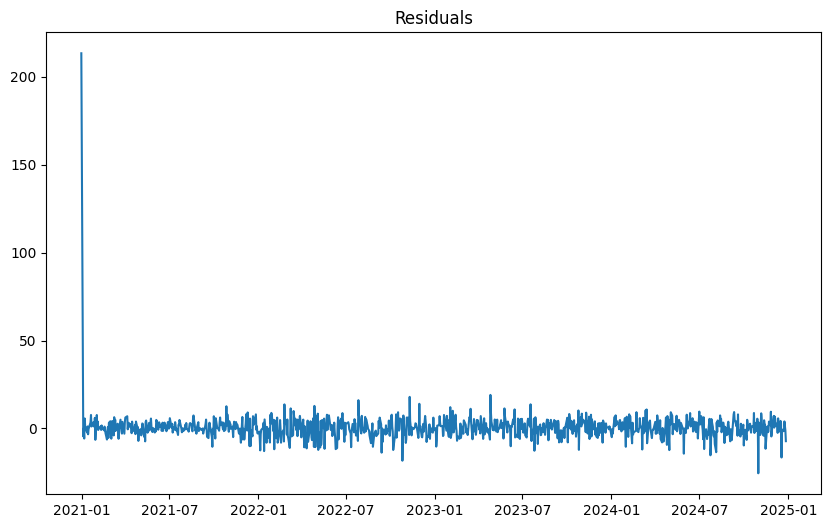

In [10]:
#Residual Analysis
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

### 4) LSTM Model

In [11]:
# Normalize the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)

In [12]:
# Prepare the data for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i+look_back, 0])
    return np.array(X), np.array(Y)

In [13]:
# train-test split
train_size = int(len(scaled_data) * 0.8)
train, test = train_test_split(scaled_data, test_size=0.2, shuffle=False)

In [14]:
# Reshape into X=t and Y=t+1
look_back = 12  # Use 1 year of historical data for prediction
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [15]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [16]:
model = Sequential([
    LSTM(50, input_shape=(look_back, 1), return_sequences=True),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

2025-12-31 10:36:30.970150: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train the model
history = model.fit(
    X_train, Y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test, Y_test),
    verbose=0
)

In [18]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train_inv = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test_inv = scaler.inverse_transform([Y_test])

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [19]:
# Calculate metrics
lstm_train_mae = mean_absolute_error(Y_train_inv[0], train_predict[:,0])
lstm_train_mse = mean_squared_error(Y_train_inv[0], train_predict[:,0])
lstm_train_rmse = np.sqrt(lstm_train_mse)
lstm_train_mape = mape(Y_train_inv[0], train_predict[:,0]) * 100

lstm_test_mae = mean_absolute_error(Y_test_inv[0], test_predict[:,0])
lstm_test_mse = mean_squared_error(Y_test_inv[0], test_predict[:,0])
lstm_test_rmse = np.sqrt(lstm_test_mse)
lstm_test_mape = mape(Y_test_inv[0], test_predict[:,0]) * 100

In [20]:
# Prepare data for comprehensive plotting
# Adjusted date ranges
train_dates = df.index[look_back:train_size]
train_actual = df.iloc[look_back:train_size]
train_predicted = pd.Series(train_predict[:,0], index=train_dates)

test_dates = df.index[train_size+look_back:]
test_actual = df.iloc[train_size+look_back:]
test_predicted = pd.Series(test_predict[:,0], index=test_dates)

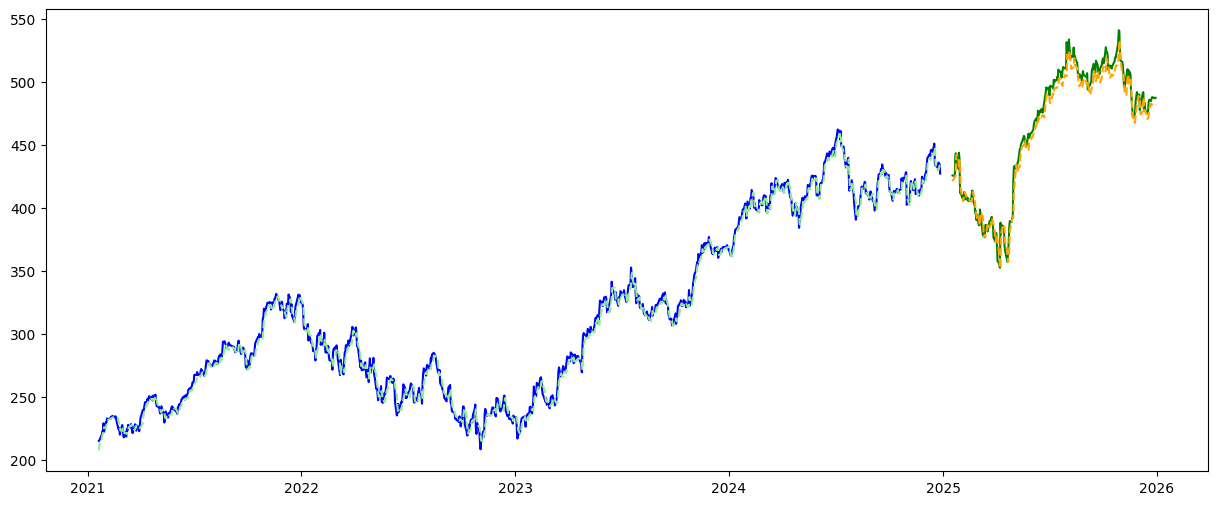

In [21]:
# Plotting
plt.figure(figsize=(15,6))
# Plot training actual and predicted
plt.plot(train_dates, train_actual, label='Training Actual', color='blue')
plt.plot(train_dates, train_predicted, label='Training Predicted', color='lightgreen', linestyle='--')

# Plot testing actual and predicted
plt.plot(test_dates, test_actual, label='Testing Actual', color='green')
plt.plot(test_dates, test_predicted, label='Testing Predicted', color='orange', linestyle='--')

### 5) Comparison of ARIMA and LSTM Models

In [22]:
# ARIMA metrics
arima_metrics = {
    'MAE': arima_mae,
    'RMSE': arima_rmse,
    'MAPE (%)': arima_mape
}

# LSTM metrics
lstm_metrics = {
    'MAE': lstm_test_mae,
    'RMSE': lstm_test_rmse,
    'MAPE (%)': lstm_test_mape
}

# COMPARISON TABLE
comparison_df = pd.DataFrame([arima_metrics, lstm_metrics], index=['ARIMA', 'LSTM']).round(4)
print("Model Performance Comparison")
print(comparison_df)

Model Performance Comparison
           MAE     RMSE  MAPE (%)
ARIMA  54.7145  61.3830   11.5225
LSTM    6.5785   8.3304    1.4221


#### Model Comparison Analysis

| Aspect | ARIMA | LSTM | Better Choice |
|------|------|------|---------------|
| **Linear Pattern Modeling** | Very strong (explicit AR structure) | Moderate | ARIMA |
| **Non-linear Pattern Modeling** | Unable to capture non-linearity | Effectively captures complex non-linear patterns | LSTM |
| **Temporal Dependency Handling** | Short-term dependencies only | Captures both short- and long-term dependencies | LSTM |
| **Response to Sudden Market Changes** | Slow adaptation | Faster adaptation due to learned dynamics | LSTM |
| **Forecast Stability** | Stable and smooth forecasts | Can be volatile if not well-regularized | ARIMA |
| **Sensitivity to Noise** | Sensitive to noise and outliers | More robust with sufficient data | LSTM |
| **Data Requirement** | Performs well with small datasets | Requires large datasets for effective training | ARIMA |
| **Training Time** | Very fast | Computationally expensive | ARIMA |
| **Hyperparameter Complexity** | Few parameters (p, d, q) | Many parameters (layers, neurons, epochs, learning rate) | ARIMA |
| **Interpretability** | High (clear statistical meaning) | Low (black-box model) | ARIMA |
| **Forecast Accuracy (This Study)** | Lower | Higher | LSTM |

### Comparative Discussion

ARIMA performs well in capturing linear temporal structures and provides stable, interpretable forecasts with minimal data requirements. However, due to its linear nature and limited memory, it struggles to model the complex, non-linear dynamics inherent in stock price movements. In contrast, the LSTM model effectively captures long-term dependencies and non-linear patterns, resulting in superior predictive performance in this study, albeit at the cost of increased computational complexity and reduced interpretability.

### Conclusion

Overall, ARIMA serves as a strong statistical baseline for time series forecasting, while LSTM demonstrates superior predictive capability for complex financial time series when sufficient data and computational resources are available.


### LSTM Residuals

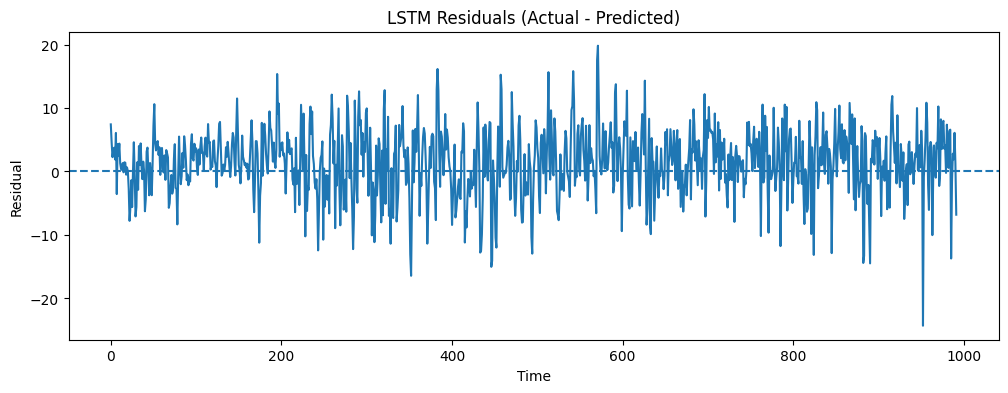

In [23]:
lstm_residuals = Y_train_inv[0] - train_predict[:,0]

plt.figure(figsize=(12,4))
plt.plot(lstm_residuals)
plt.axhline(0, linestyle='--')
plt.title('LSTM Residuals (Actual - Predicted)')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.show()

### Learning Curve

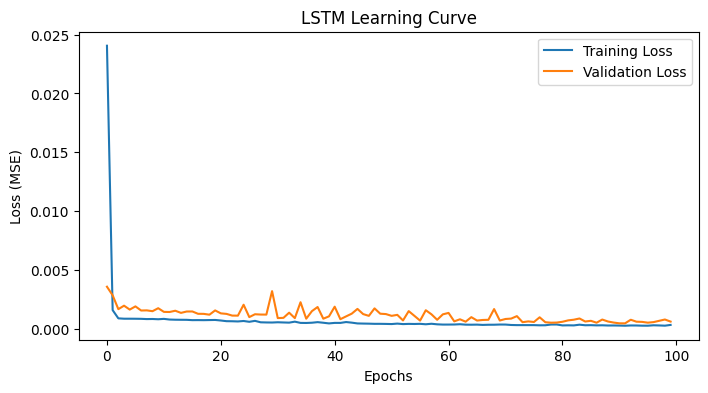

In [24]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()
